In [269]:
# Import Libraries

import numpy as np # Provides array objects for calculations
from numpy import cumsum
import pandas as pd # For dataframe and data manipulations
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA # To perform ARIMA analysis
from statsmodels.tsa.statespace.sarimax import SARIMAX # To perform Seasonal ARIMA Analysis
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_predict, plot_acf, plot_pacf # Plot ACF, PACF and predict
from statsmodels.tsa.stattools import adfuller, acf # Import augmented dickey fuller and auto correlation function
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import seasonal_decompose # import seasonal decompose
from scipy.signal import periodogram # For Periodogram
from datetime import datetime # For datetime functions
from pandas.plotting import autocorrelation_plot # Look for seasonality in data
from sklearn.metrics import mean_squared_error, mean_absolute_error # to evaluate models based on error

import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell # Importing so we can run multiple lines in one cell`==
InteractiveShell.ast_node_interactivity = "all" # Code so multiple lines in one cell can be ran simultaenously`==
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import joblib # to save and load the model

In [270]:
df = pd.read_csv('medical_time_series.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


# Time Step Formatting and Data Preparation

In [271]:
# Time step formatting - checking for gaps
# Check for missing values
print('Missing values:\n', df.isnull().sum())

Missing values:
 Day        0
Revenue    0
dtype: int64


In [272]:
# Convert 'Day' column into a proper datetime index (assuming start date is 2024-01-01)
# Check for gaps in sequence
df['Date'] = pd.to_datetime(df['Day'], origin='2023-12-31', unit='D')
df.set_index('Date', inplace=True)

# Check if there are missing days
missing_days = pd.date_range(start=df.index.min(), end=df.index.max()).difference(df.index)
print(f"Number of missing days: {len(missing_days)}")

print(f"Date range: {df.index[0]} to {df.index[-1]}")

#Check that the days are ordered
print(df.index.is_monotonic_increasing)

Number of missing days: 0
Date range: 2024-01-01 00:00:00 to 2025-12-31 00:00:00
True


In [273]:
# Replaces day with date column
df.drop(columns=['Day'], inplace=True)

In [274]:
df=df.dropna()
df.info()
df.head()
df.tail()
df.isnull().any()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2024-01-01 to 2025-12-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


,Revenue
Date,
2024-01-01,0.000000
2024-01-02,-0.292356
2024-01-03,-0.327772
2024-01-04,-0.339987
2024-01-05,-0.124888


,Revenue
Date,
2025-12-27,15.722056
2025-12-28,15.865822
2025-12-29,15.708988
2025-12-30,15.822867
2025-12-31,16.069429


Revenue    False
dtype: bool

In [275]:
# Export cleaned dataframe to .csv
pd.DataFrame(df).to_csv("cleaned_medical_time_series.csv")

# Line Graph of Time Series

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Revenue Over Time')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Millions USD')

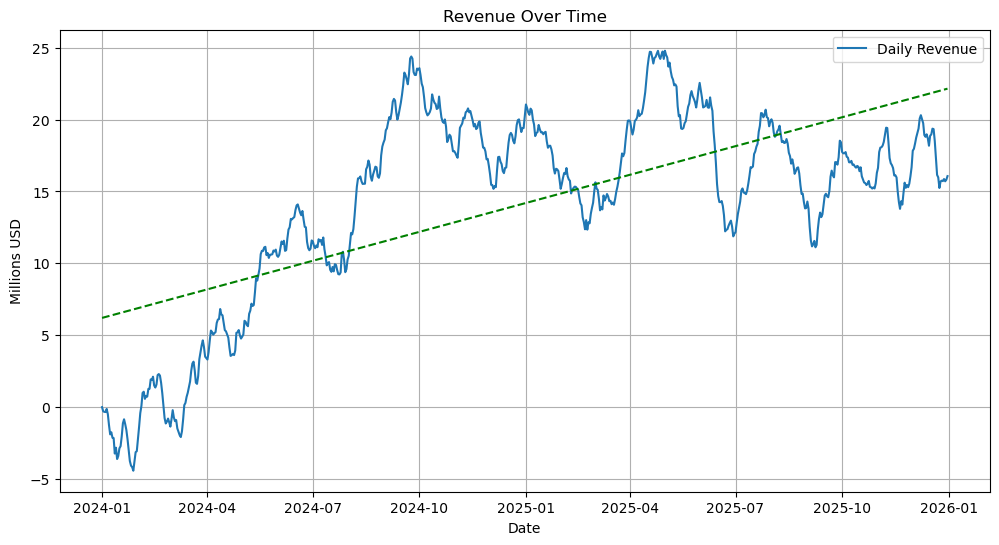

In [276]:
# Plot the data to visualize possible trends
plt.figure(figsize = (12, 6))
plt.plot(df.Revenue, label="Daily Revenue")
plt.title("Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Millions USD")
plt.legend()
plt.grid(True)
# Generate trend line
x = mdates.date2num(df.index)
y = df.Revenue
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
# Plot trendline
plt.plot(x, p(x), "g--")
plt.show()

The revenue data is upward sloping. 

# Stationarity Evaluation

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Revenue in Millions Over Two Years')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Revenue in Million Dollars')

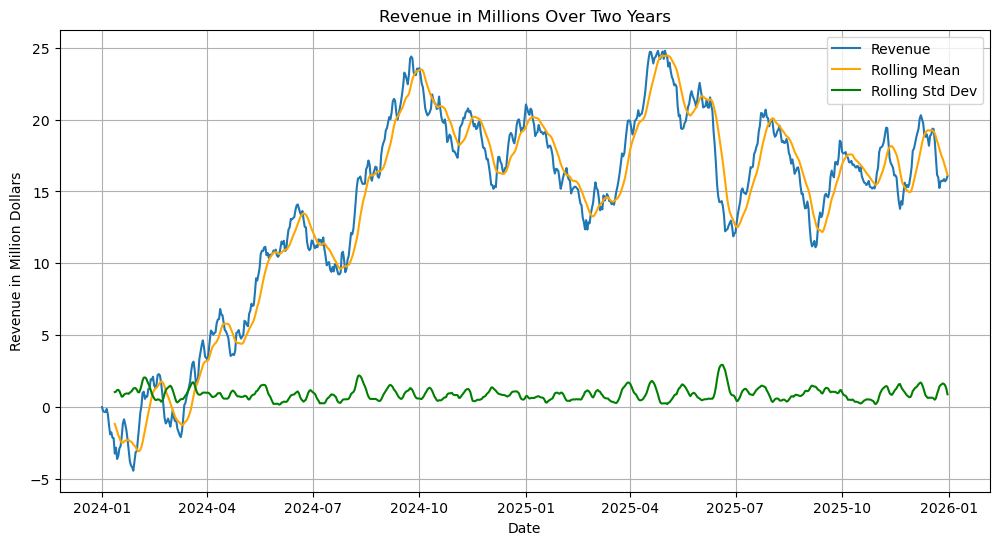

In [277]:
# Calculate rolling mean and rolling standard deviation for finding Stationarity - 12 month/yearly window
# Trend is the smooth long-term tendency of a time series. Trends can increase or decrease.
# An easy way to visualize Trends is with rolling means.
rolling_mean = df['Revenue'].rolling(window=12).mean()
rolling_std = df['Revenue'].rolling(window=12).std()

# Plot the time series, rolling mean, and rolling standard deviation
plt.figure(figsize=(12, 6))
plt.plot(df['Revenue'], label='Revenue')
plt.plot(rolling_mean, color='orange', label='Rolling Mean')
plt.plot(rolling_std, color='green', label='Rolling Std Dev')
plt.title('Revenue in Millions Over Two Years')
plt.xlabel('Date')
plt.ylabel('Revenue in Million Dollars')
plt.legend()
plt.grid(True)
plt.show()

In [278]:
# Check for stationarity using Augmented Dickey-Fuller Test
df_test = adfuller(df['Revenue'], autolag='AIC')
df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','# lags used','# of observations'])

for key,value in df_test[4].items():
    df_output['Critical// Value(%s)'%key] = value

print(df_output)

Test Statistic            -2.218319
p-value                    0.199664
# lags used                1.000000
# of observations        729.000000
Critical// Value(1%)      -3.439352
Critical// Value(5%)      -2.865513
Critical// Value(10%)     -2.568886
dtype: float64


In [279]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(df,train_size=0.8, test_size=0.2, shuffle=False) # Using 80% of the data for training

# Verify the split
print("Training set shape:", train.shape)
print("Testing set shape:", test.shape)
print(f"Training data from {train.index[0]} to {train.index[-1]}")
print(f"Test data from {test.index[0]} to {test.index[-1]}")

train.to_csv('D213_task1_train.csv')
test.to_csv('D213_task1_test.csv')

Training set shape: (584, 1)
Testing set shape: (147, 1)
Training data from 2024-01-01 00:00:00 to 2025-08-06 00:00:00
Test data from 2025-08-07 00:00:00 to 2025-12-31 00:00:00


Differencing works on lags. Lags are time series datapoints. They can be daily, weekly, monthly, yearly, etc. Lags or lag operator is a function that shifts a time series so lagged values and aligned with the actual time series. The lags can be shifted any number of units. Lags are important because of autocorrelation, a tendency for values to be correlated with previous ones. Autoregression regresses a time series over previous values so that we can forecast or predict future tendency.

Test Statistic:  -17.374772303557066
P-value:  5.113206978840171e-30
Critical Values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Differenced Revenue in Millions Over Two Years')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Differenced Revenue in Million Dollars')

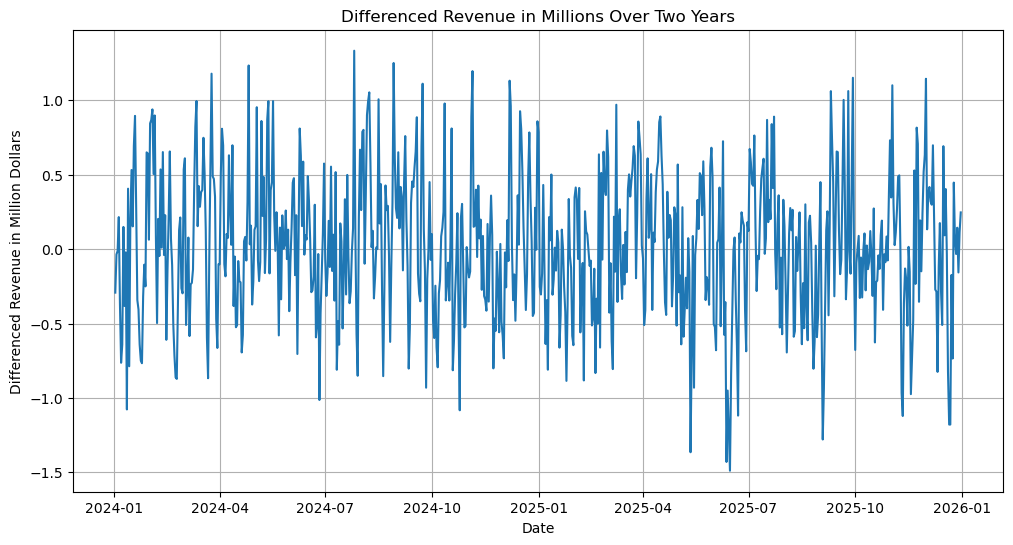

In [280]:
# Difference the data to make it stationary - first order differencing along with dropping NaN values
df_diff = df.diff().dropna()

# Perform Augmented Dickey-Fuller test on differenced data. This gives us our 'd' value for ARIMA. 
diff_result = adfuller(df_diff['Revenue'])
print('Test Statistic: ', diff_result[0])
print('P-value: ', diff_result[1])
print('Critical Values: ', diff_result[4])

# Plot the differenced data
plt.figure(figsize=(12, 6))
plt.plot(df_diff['Revenue'])
plt.title('Differenced Revenue in Millions Over Two Years')
plt.xlabel('Date')
plt.ylabel('Differenced Revenue in Million Dollars')
plt.grid(True)
plt.show()

The data is stationary due to significant p-value. The data does center on zero. 

Text(0.5, 1.0, 'Original Time Series')

Text(0.5, 1.0, 'Trend Component')

Text(0.5, 1.0, 'Seasonal Component')

Text(0.5, 1.0, 'Residual Component')

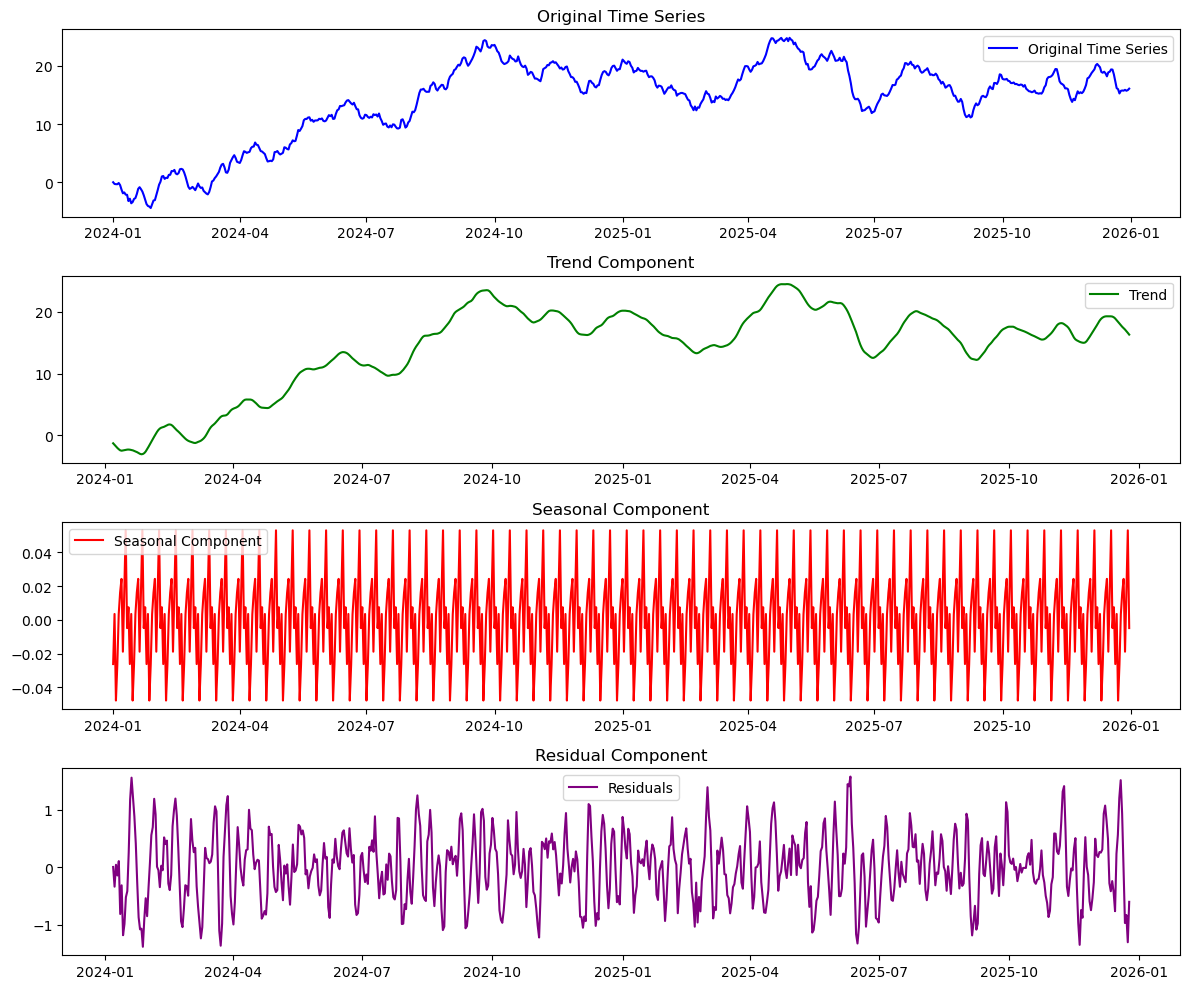

In [281]:
# ----------- Decomposing the Time Series ----------- uses 12 for monthly data that repeats every year/12 months
# Additive: xt = Trend + Seasonal + Random
# The additive model is useful when the seasonal variation is relatively constant over time.
decomposition = seasonal_decompose(df['Revenue'], model='additive', period=12)

# Plot the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
axes[0].plot(df.index, df['Revenue'], label="Original Time Series", color='blue')
axes[0].set_title("Original Time Series")
axes[0].legend()

axes[1].plot(decomposition.trend, label="Trend", color='green')
axes[1].set_title("Trend Component")
axes[1].legend()

axes[2].plot(decomposition.seasonal, label="Seasonal Component", color='red')
axes[2].set_title("Seasonal Component")
axes[2].legend()

axes[3].plot(decomposition.resid, label="Residuals", color='purple')
axes[3].set_title("Residual Component")
axes[3].legend()

plt.tight_layout()
plt.show()

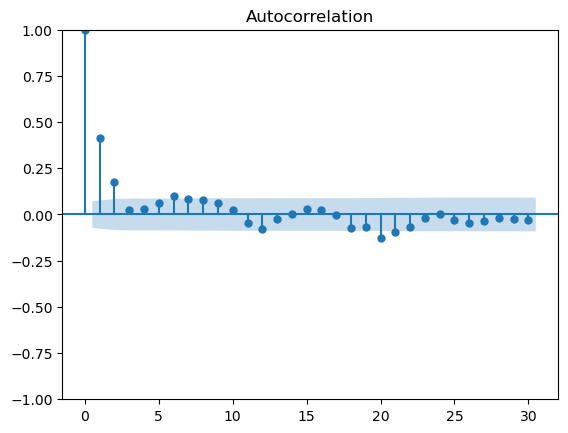

Text(0.5, 1.0, 'Autocorrelation Function (ACF) of Revenue Time Series')

Text(0.5, 4.444444444444445, 'Lags')

Text(4.444444444444452, 0.5, 'Autocorrelation')

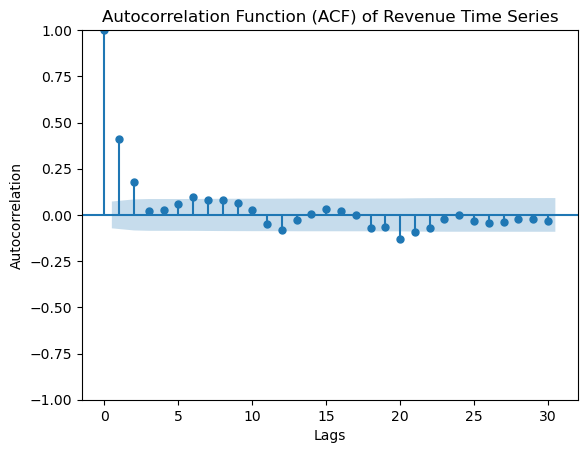

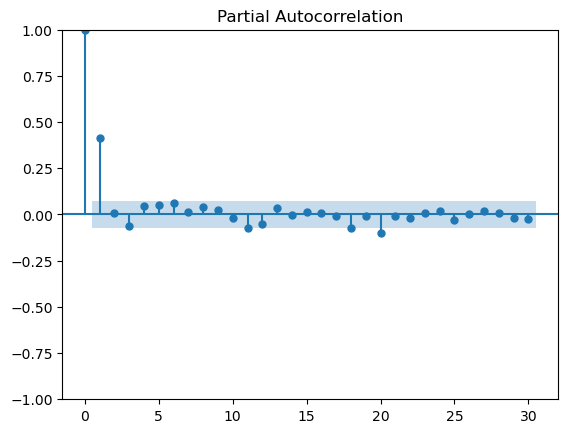

Text(0.5, 1.0, 'Partial Autocorrelation Function (ACF) of Revenue Time Series')

Text(0.5, 4.444444444444445, 'Lags')

Text(4.444444444444452, 0.5, 'Autocorrelation')

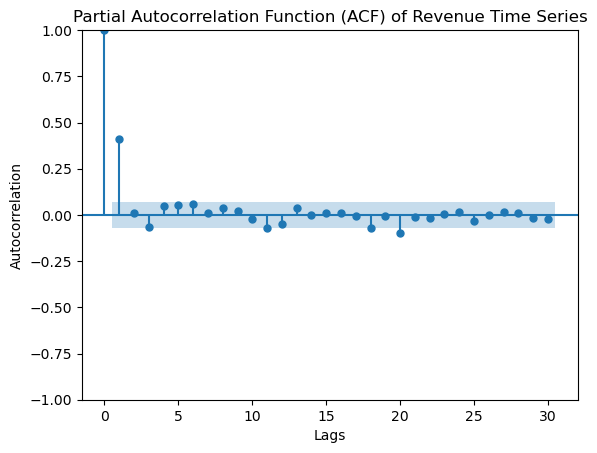

In [282]:
# Plot ACF and PACF
# ACF provides the 'q' value for the ARIMA model. PACF provides the 'p' value for the ARIMA. 
plot_acf(df_diff['Revenue'].dropna(), lags=30)
plt.title("Autocorrelation Function (ACF) of Revenue Time Series")
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

plot_pacf(df_diff['Revenue'].dropna(), lags=30)
plt.title("Partial Autocorrelation Function (ACF) of Revenue Time Series")
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Frequency')

Text(0, 0.5, 'Power Spectral Density')

Text(0.5, 1.0, 'Spectral Density of the Revenue Time Series')

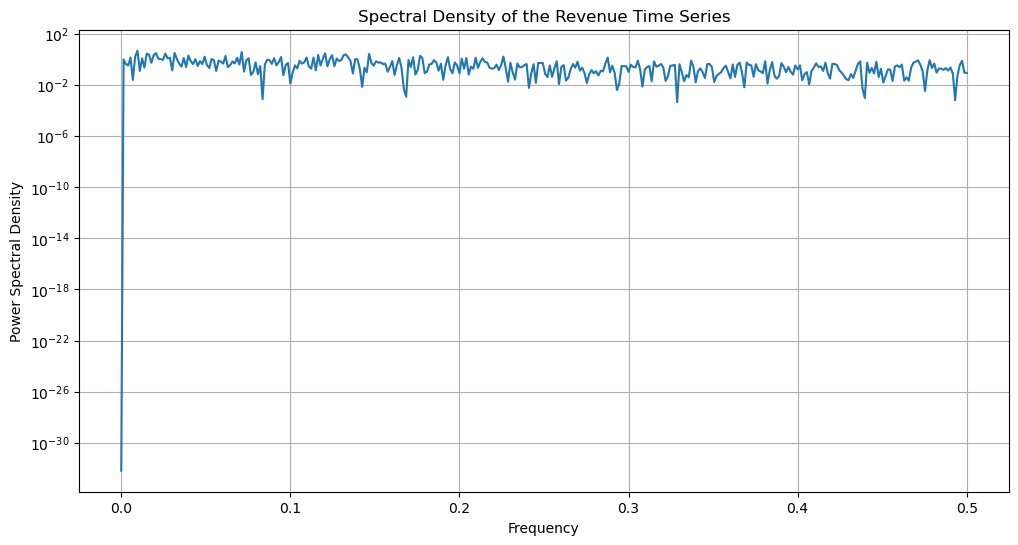

In [283]:
# Spectral Density Plot - differenced data used here
frequencies, power_spectral_density = periodogram(df_diff['Revenue'].dropna(), scaling='density')

plt.figure(figsize=(12, 6))
plt.semilogy(frequencies, power_spectral_density)
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.title("Spectral Density of the Revenue Time Series")
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Residuals of Decomposed Time Series')

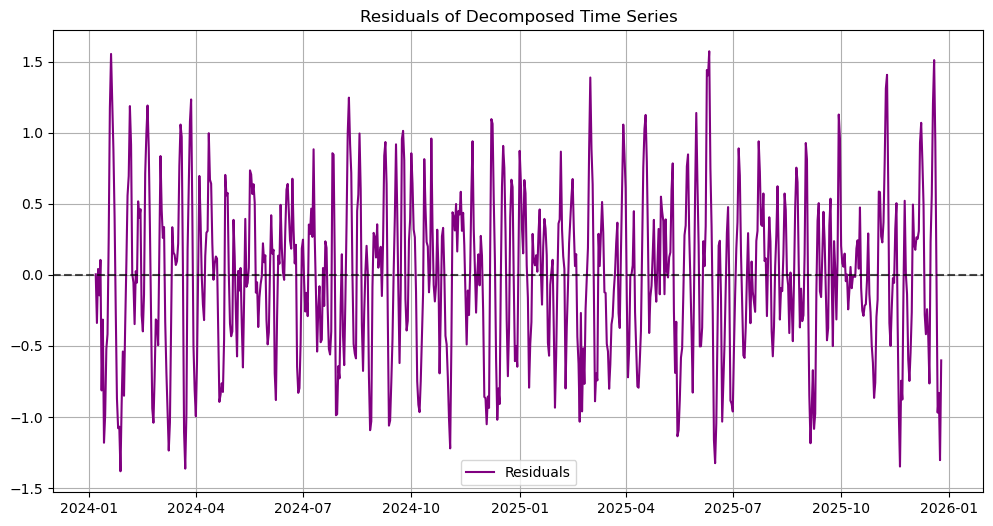

In [284]:
# Visualization 4: Checking Residuals for Trends
plt.figure(figsize=(12, 6))
plt.plot(decomposition.resid, label="Residuals", color='purple')
plt.axhline(y=0, linestyle='--', color='black', alpha=0.7)
plt.title("Residuals of Decomposed Time Series")
plt.legend()
plt.grid(True)
plt.show()

In [285]:
# Fit auto_arima function on non stationary data - accounts for observed trend and seasonality of the time series data
auto_model = auto_arima(df['Revenue'], seasonal=False, trace=True,
                        error_action='ignore', suppress_warnings=True, stepwise=True) # set to stepwise

# To print the summary
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=883.277, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1015.972, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=881.359, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=906.199, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1015.481, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=883.300, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=883.314, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=883.348, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=879.982, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=881.911, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=881.927, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=905.166, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=881.947, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.579 seconds
                               SA

In [286]:
# Set up the frequency parameter in the train data
train.index = pd.to_datetime(train.index)
train = train.asfreq('D')

# Fit the manual ARIMA model on training data
model = ARIMA(train['Revenue'], order=(1, 1, 0))
results = model.fit()

# Print the summary of the model
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -350.812
Date:                Wed, 08 Oct 2025   AIC                            705.625
Time:                        19:52:36   BIC                            714.361
Sample:                    01-01-2024   HQIC                           709.030
                         - 08-06-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4106      0.038     10.837      0.000       0.336       0.485
sigma2         0.1950      0.012     15.888      0.000       0.171       0.219
Ljung-Box (L1) (Q):                   0.15   Jarque-

2025-08-07    19.299360
2025-08-08    19.345870
2025-08-09    19.364967
2025-08-10    19.372809
2025-08-11    19.376029
                ...    
2025-12-27    19.378272
2025-12-28    19.378272
2025-12-29    19.378272
2025-12-30    19.378272
2025-12-31    19.378272
Freq: D, Name: predicted_mean, Length: 147, dtype: float64


<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Actual Revenue vs Predicted Revenue')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Millions USD')

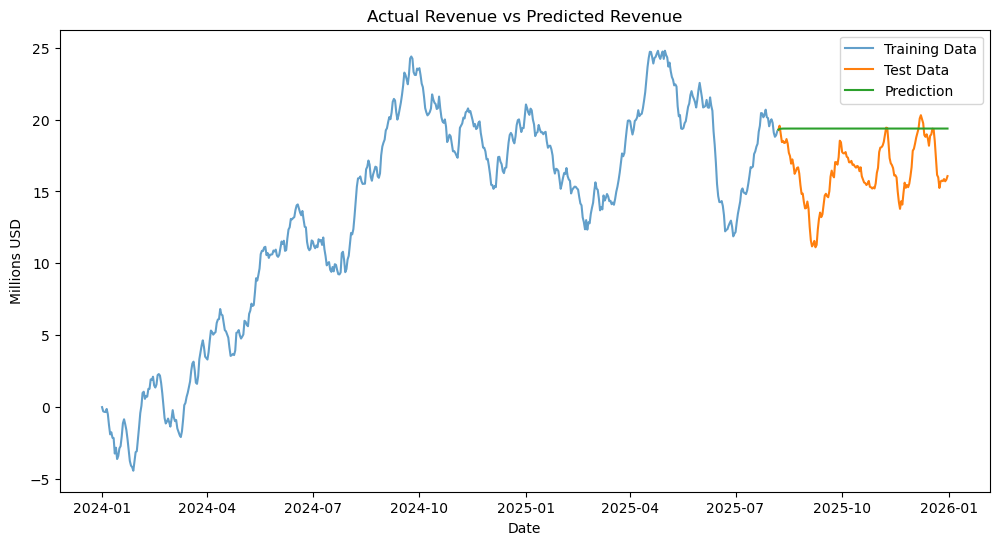

In [289]:
# Forecast on test - define the size of data set
start = len(train)
end = start + len(test) - 1

# Use get_forecast
forecast_test = results.get_forecast(steps=len(test))
forecast_test_mean = forecast_test.predicted_mean
print(forecast_test_mean)

# Set the index of the prediction series to match the test set
forecast_test_mean.index = test.index

#Visualize predictions vs actual data using the test data as a comparison
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data', alpha=0.7)
plt.plot(test.index, test, label='Test Data')
plt.plot(test.index, forecast_test_mean, label='Prediction')
#plt.fill_between(test.index, lower_limit, upper_limit, alpha=0.2, label='Confidence Interval')
plt.title("Actual Revenue vs Predicted Revenue")
plt.xlabel("Date")
plt.ylabel("Millions USD")
plt.legend()
plt.show()

In [290]:
# Predict the next 3 months
# Determine the start date for the forecast
start_date = test.index[-1] + pd.Timedelta(days=1)
# Create the date index for 3 months of daily predictions
index_future_dates = pd.date_range(start=start_date, periods=90)

# Use get_forecast to predict the next 3 months
forecast_next_3_months = results.get_forecast(steps=90)
mean_prediction = forecast_next_3_months.predicted_mean
confidence_intervals = forecast_next_3_months.conf_int()
lower_limits = confidence_intervals.iloc[:, 0]
upper_limits = confidence_intervals.iloc[:, 1]

# Set the index of the prediction series to match the future dates
mean_prediction.index = index_future_dates
lower_limits.index = index_future_dates
upper_limits.index = index_future_dates

print(mean_prediction)

2026-01-01    19.299360
2026-01-02    19.345870
2026-01-03    19.364967
2026-01-04    19.372809
2026-01-05    19.376029
2026-01-06    19.377351
2026-01-07    19.377894
2026-01-08    19.378117
2026-01-09    19.378208
2026-01-10    19.378246
2026-01-11    19.378261
2026-01-12    19.378268
2026-01-13    19.378270
2026-01-14    19.378271
2026-01-15    19.378272
2026-01-16    19.378272
2026-01-17    19.378272
2026-01-18    19.378272
2026-01-19    19.378272
2026-01-20    19.378272
2026-01-21    19.378272
2026-01-22    19.378272
2026-01-23    19.378272
2026-01-24    19.378272
2026-01-25    19.378272
2026-01-26    19.378272
2026-01-27    19.378272
2026-01-28    19.378272
2026-01-29    19.378272
2026-01-30    19.378272
2026-01-31    19.378272
2026-02-01    19.378272
2026-02-02    19.378272
2026-02-03    19.378272
2026-02-04    19.378272
2026-02-05    19.378272
2026-02-06    19.378272
2026-02-07    19.378272
2026-02-08    19.378272
2026-02-09    19.378272
2026-02-10    19.378272
2026-02-11    19

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Training, Test Data, and 3-Month Forecast')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Revenue')

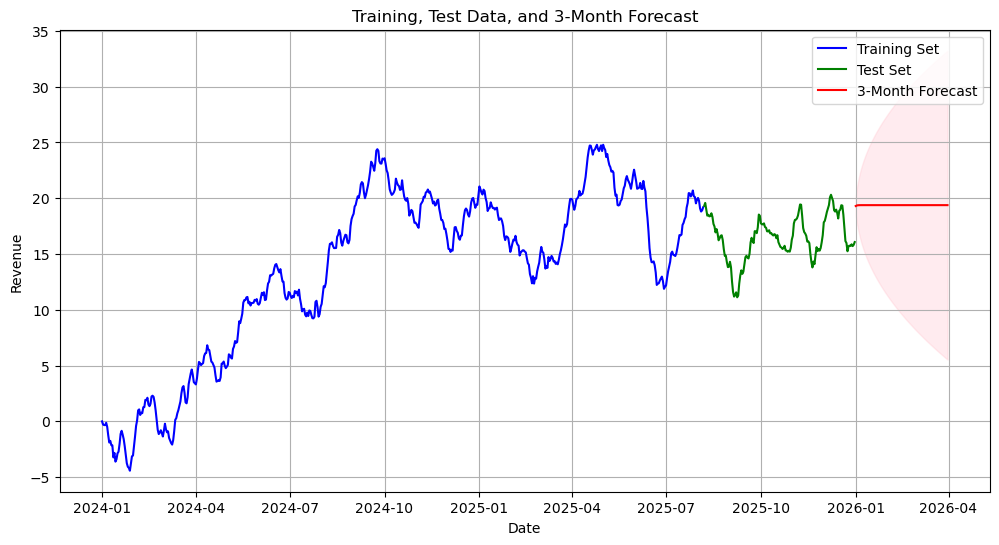

In [291]:
# Plot the Entire dataset with the 3-month forecast
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Revenue'], label='Training Set', color='blue')
plt.plot(test.index, test['Revenue'], label='Test Set', color='green')
plt.plot(mean_prediction.index, mean_prediction, color='red', label='3-Month Forecast')
plt.fill_between(mean_prediction.index, lower_limits, upper_limits, color='pink', alpha=0.3)
plt.title('Training, Test Data, and 3-Month Forecast')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1600x1200 with 0 Axes>

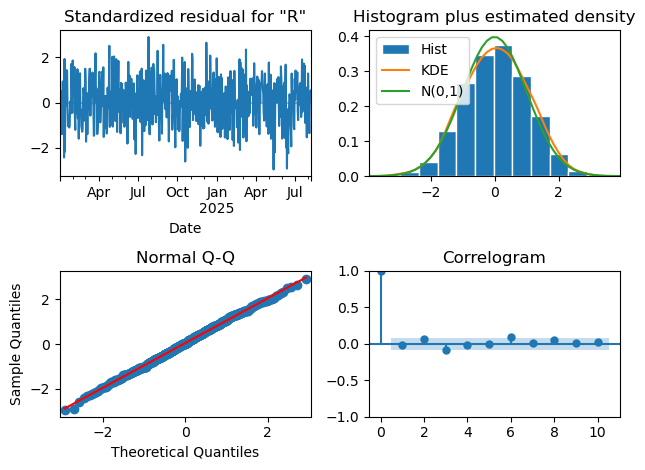

In [292]:
# Set figure size
plt.figure(figsize=[16, 12])

# Plot diagnostics
results.plot_diagnostics()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show();

In [293]:
# Evaluate the model
mae = mean_absolute_error(test["Revenue"], forecast_test_mean)
mse = mean_squared_error(test["Revenue"], forecast_test_mean)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 2.9836709993604984
Mean Squared Error (MSE): 12.679409705287162
Root Mean Squared Error (RMSE): 3.5608158763529407
